## tradingmodel_template_v5
- Future Development
    - live price feed API
      - develop a Pagify API function
        - attempts pulls from multiple API's at a rate lower than data limits
        - this will allow me to have live feed data coming in and not have to pay for it
    - convert data frames to generic labeling 

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

### 1 : Get data as multiple CSV
- need to create generic version using print formatting to generate file names
- future development
    - live feed via pagified APIs

In [197]:
csv_files = ["Binance_BTCUSDT_1h.csv", "Binance_BTCUSDT_d.csv"]
dataframes = []

for file in csv_files:
    try:
        df = pd.read_csv(file, skiprows=1)
        dataframes.append(df)
    except FileNotFoundError:
        print(f"Error: File not found - {file}")
        dataframes.append(None)

# Check for missing data
if dataframes[1] is None:
    print("Daily data is missing. Proceeding with hourly data only.")
    btc_1h = dataframes[0]
    # Placeholder for when daily data is added
    btc_combined = btc_1h.copy()
else:
    btc_1h, btc_1 = dataframes
    print("Files loaded successfully.")

    # Multi-Timeframe Integration
    btc_1h["time"] = pd.to_datetime(btc_1h["Unix"], unit="ms")
    btc_1["time"] = pd.to_datetime(btc_1["Unix"], unit="ms")
    btc_1h.set_index("time", inplace=True)
    btc_1.set_index("time", inplace=True)

    # Join dataframes
    btc_combined = btc_1h.join(btc_1, how="inner", lsuffix="_1h", rsuffix="_d")

Files loaded successfully.


In [199]:
# Data Verification
# Verify basic structure
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"------------------------------ {name} Data ------------------------------")
    print("Shape:", df.shape)
    print("Columns:", df.columns)
    print("Data Types:\n", df.dtypes)
    print(df.head(), "\n")
    print(df.describe(), "\n")
    print("------------------------------------------------------------------------")

------------------------------ Hourly Data ------------------------------
Shape: (64012, 10)
Columns: Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume BTC',
       'Volume USDT', 'tradecount'],
      dtype='object')
Data Types:
 Unix             int64
Date            object
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume BTC     float64
Volume USDT    float64
tradecount       int64
dtype: object
                              Unix                 Date   Symbol      Open  \
time                                                                         
2024-12-10 23:00:00  1733871600000  2024-12-10 23:00:00  BTCUSDT  96849.45   
2024-12-10 22:00:00  1733868000000  2024-12-10 22:00:00  BTCUSDT  96858.00   
2024-12-10 21:00:00  1733864400000  2024-12-10 21:00:00  BTCUSDT  96434.75   
2024-12-10 20:00:00  1733860800000  2024-12-10 20:00:00  BTCUSDT  95856.50   
2024-12-10 19:00:00  1733857200000 

In [201]:
# Check for missing values
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"--- Missing Values in {name} Data ---")
    print(df.isnull().sum(), "\n")

--- Missing Values in Hourly Data ---
Unix           0
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 

--- Missing Values in Daily Data ---
Unix           0
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 



#### Confirm dataframes[] contains dataframes for desired time periods

In [204]:
btc_1h = dataframes[0]
btc_d = dataframes[1]
print(btc_1h.head())
print(btc_d.head())

                              Unix                 Date   Symbol      Open  \
time                                                                         
2024-12-10 23:00:00  1733871600000  2024-12-10 23:00:00  BTCUSDT  96849.45   
2024-12-10 22:00:00  1733868000000  2024-12-10 22:00:00  BTCUSDT  96858.00   
2024-12-10 21:00:00  1733864400000  2024-12-10 21:00:00  BTCUSDT  96434.75   
2024-12-10 20:00:00  1733860800000  2024-12-10 20:00:00  BTCUSDT  95856.50   
2024-12-10 19:00:00  1733857200000  2024-12-10 19:00:00  BTCUSDT  95132.04   

                         High       Low     Close  Volume BTC   Volume USDT  \
time                                                                          
2024-12-10 23:00:00  97128.62  96402.70  96593.00  1199.51886  1.161477e+08   
2024-12-10 22:00:00  97099.49  96587.43  96849.44  1109.33596  1.074380e+08   
2024-12-10 21:00:00  97200.70  96382.35  96858.00  2026.89962  1.961670e+08   
2024-12-10 20:00:00  96700.00  95616.00  96434.76  1949.38

#### dataframes[0] & dataframes[1] are verified
-----------------------------------------------

### 2 : Begin multitimeframe integration
- Ensure proper datatime format and set time as index
    - time is the index because we refer to prices by their periods
    - switch from UNIX to datatime format


In [208]:
# Convert time columns to datetime format and set as index then drop old timestamps
# encounter missing Unix error, reload csv's.. perhaps error occurs in 
for df in dataframes:
    df["time"] = pd.to_datetime(df["Unix"], unit="ms")
    df.set_index("time", inplace=True)
    df.drop(columns=["Unix"], inplace=True)

#### 2.1 : create combined dataframe
- change btc_combined to "combined" for future pair integrations

In [211]:
# Align and merge hourly and daily data
btc_combined = btc_1h.join(btc_d, how="inner", lsuffix="_1h", rsuffix="_d")

------- Hourly Time Range --------
2017-08-17 04:00:00 to 2024-12-10 23:00:00
-------- Daily Time Range --------
2017-08-17 00:00:00 to 2024-12-10 00:00:00
------- Combined Time Range ------
2017-08-18 00:00:00 to 2024-12-07 00:00:00
--- Sample Combined Timestamps ---
DatetimeIndex(['2024-12-07', '2024-12-06', '2024-12-05', '2024-12-04',
               '2024-12-03'],
              dtype='datetime64[ns]', name='time', freq=None)


<Axes: xlabel='time'>

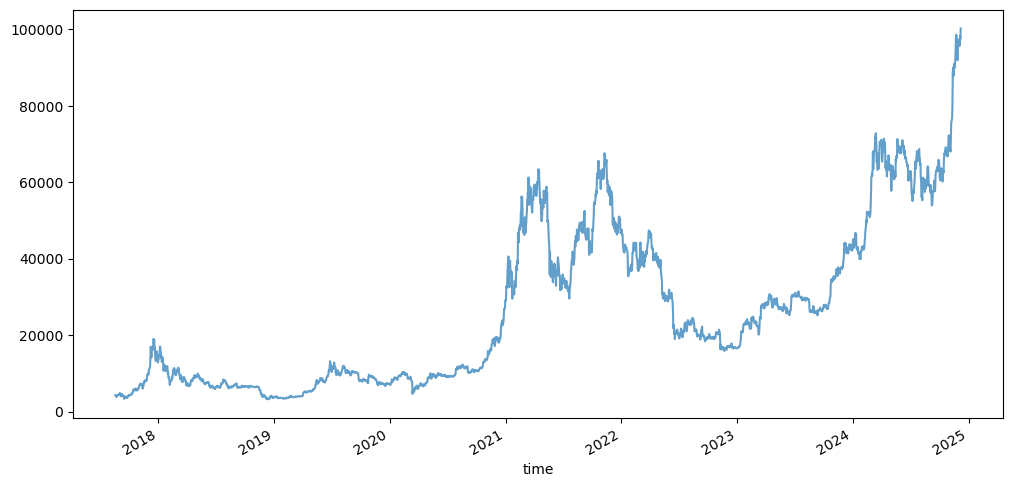

In [213]:
# verify the time ranges
print("------- Hourly Time Range --------")
print(btc_1h.index.min(), "to", btc_1h.index.max())

print("-------- Daily Time Range --------")
print(btc_d.index.min(), "to", btc_d.index.max())

print("------- Combined Time Range ------")
print(btc_combined.index.min(), "to", btc_combined.index.max())

# Verify timestamp alignment in combined data
print("--- Sample Combined Timestamps ---")
print(btc_combined.index[:5])

# Plot Close Prices to verify alignment
plt.figure(figsize=(12, 6))
btc_combined["Close_1h"].plot(label="Hourly Close", alpha=0.7)


#### 2.2 Normalization and logarithmic Scaling

           Open_1h      High_1h       Low_1h     Close_1h  Volume BTC_1h  \
count  2666.000000  2666.000000  2666.000000  2666.000000    2666.000000   
mean      9.818279     9.823993     9.812312     9.818460       7.401711   
std       0.894427     0.894073     0.894870     0.894424       1.170326   
min       8.067466     8.078651     8.056113     8.075583       1.207145   
25%       9.047050     9.050365     9.037086     9.047077       6.852375   
50%       9.902327     9.909877     9.898703     9.904518       7.397468   
75%      10.633304    10.639521    10.629014    10.635773       8.066526   
max      11.510341    11.516989    11.508219    11.515652      11.108869   

       Volume USDT_1h  tradecount_1h       Open_d       High_d        Low_d  \
count     2666.000000    2666.000000  2666.000000  2666.000000  2666.000000   
mean        17.217838      10.320683     9.818279     9.843511     9.790120   
std          1.615459       1.462705     0.894427     0.893122     0.896574   

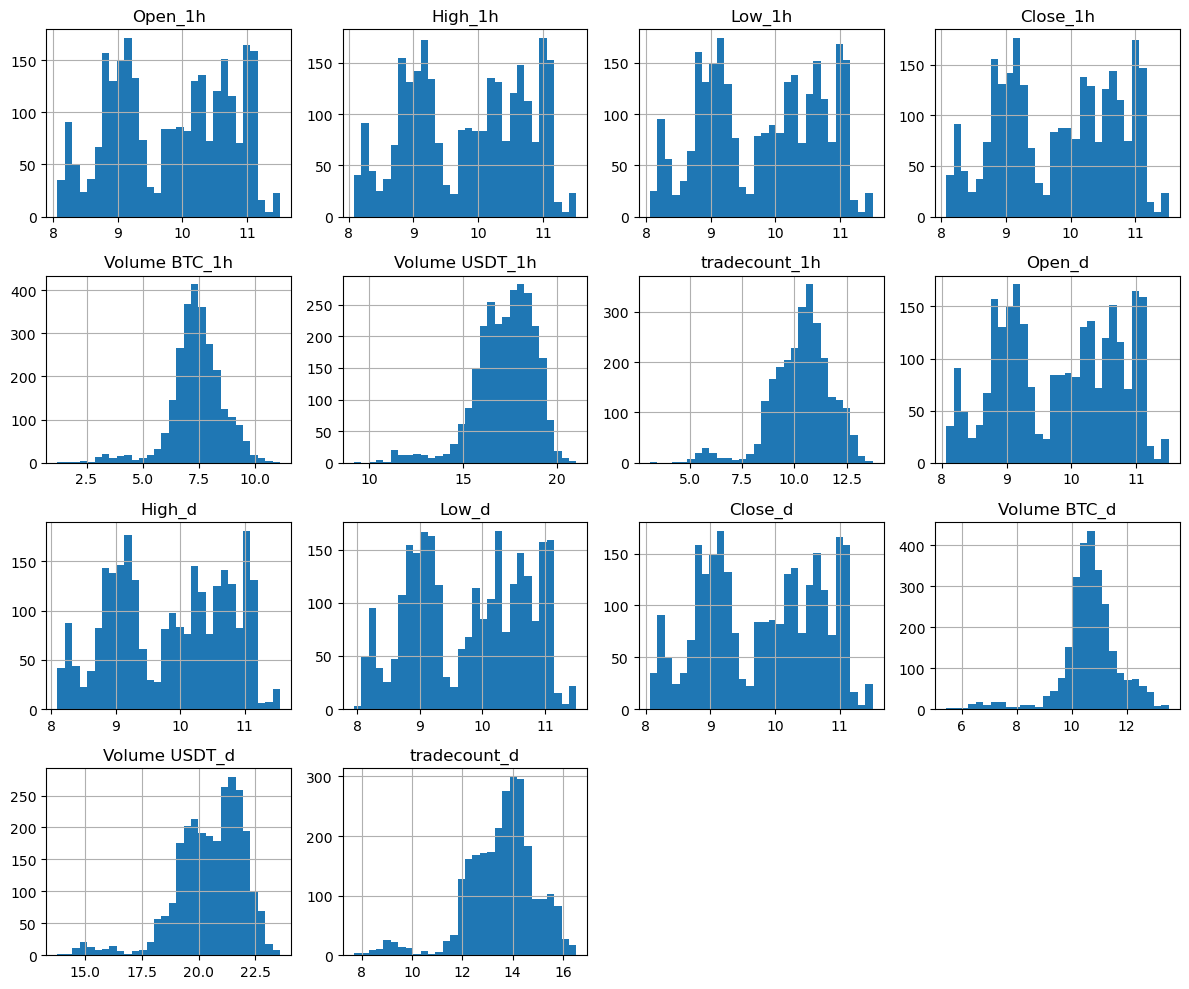

In [215]:
# Normalize numeric columns using log scaling
numeric_cols = btc_combined.select_dtypes(include=["float64", "int64"]).columns
btc_combined[numeric_cols] = btc_combined[numeric_cols].apply(
    lambda x: np.log1p(x.clip(lower=1e-9))
)
# normalize 
scaler = StandardScaler()

# Check descriptive statistics after normalization
print(btc_combined[numeric_cols].describe())

# Plot histograms to ensure normalization effect
btc_combined[numeric_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

#### --------------- Merged and Cleaned (pre-indicator implementation) ---------------

### 3 : Feature Engineering
- This section puts the indicators on the cleaned "btc_combined" dataset
- indicator implementations (Add New Indicators Here)
    - Smoothed Moving Averages(SMA)
    - Relative Strength Index (RSI)
    - MAConvergenceDivergence (MACD)

##### Implement SMA_20, SMA_50

In [246]:
btc_combined["SMA_20"] = btc_combined["Close_1h"].rolling(window=20).mean()
btc_combined["SMA_50"] = btc_combined["Close_1h"].rolling(window=50).mean()

##### Implement RSI

In [251]:
btc_combined["RSI"] = 100 - (100 / (1 + (btc_combined["Close_1h"].diff(1).clip(lower=0).rolling(14).mean() /
                                        -btc_combined["Close_1h"].diff(1).clip(upper=0).rolling(14).mean())))

##### Implement MACD & MACD Signal Line

In [256]:
btc_combined["MACD"] = (btc_combined["Close_1h"].ewm(span=12, adjust=False).mean() -
                         btc_combined["Close_1h"].ewm(span=26, adjust=False).mean())

In [258]:
btc_combined["Signal_Line"] = btc_combined["MACD"].ewm(span=9, adjust=False).mean()

### 4 : Generate signals using indicator data

##### 4.1 SMA Crossover Signals
- identify long term trend
-  1: buy
- -1: sell
-  0: hold

In [269]:
btc_combined["Signal_SMA"] = np.where(                                          
    (btc_combined["SMA_20"].shift(1) <= btc_combined["SMA_50"].shift(1)) & 
    (btc_combined["SMA_20"] > btc_combined["SMA_50"]), 1, np.where(
        (btc_combined["SMA_20"].shift(1) >= btc_combined["SMA_50"].shift(1)) & 
        (btc_combined["SMA_20"] < btc_combined["SMA_50"]),
        -1,  # Sell Signal
        0)
    )